# Gaussian Causal Discovery Example

This notebook demonstrates causal network discovery using the **Gaussian** information method with synthetic data.

## Overview
- Generate synthetic Gaussian time series with known causal structure
- Visualize the oscillator dynamics and network structure
- Apply causal discovery using Gaussian conditional mutual information
- Evaluate performance using ROC-AUC metric

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Import causal discovery components
from causalentropy.core.discovery import discover_network
from causalentropy.datasets.synthetic import linear_stochastic_gaussian_process

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Create Ground Truth Network

We'll create a directed graph that represents the true causal relationships.

In [2]:
# Create a ground truth network
n_nodes = 5
seed = 42
p = 0.2 

# Create a specific network structure
np.random.seed(seed)
G_true = nx.erdos_renyi_graph(n_nodes, p, seed=seed, directed=True)

print(f"Ground truth network has {G_true.number_of_nodes()} nodes and {G_true.number_of_edges()} edges")
print(f"Edges: {list(G_true.edges())}")

# Get adjacency matrix for later comparison
A_true = nx.to_numpy_array(G_true)
print(f"\nGround truth adjacency matrix:")
print(A_true)

Ground truth network has 5 nodes and 6 edges
Edges: [(0, 2), (1, 4), (2, 1), (3, 0), (3, 1), (4, 3)]

Ground truth adjacency matrix:
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


## 2. Generate Synthetic Time Series Data

Generate Gaussian time series data with the known causal structure.

In [4]:
# Generate synthetic Gaussian time series
T = 200  # Time series length
rho = 0.7  # Coupling strength

# Generate data using linear stochastic process
data, A = linear_stochastic_gaussian_process(
    rho=rho,
    n=n_nodes,
    T=T,
    p=0.2,
    seed=seed,
    G=G_true
)

print(f"Generated time series data with shape: {data.shape}")
print(f"Data statistics:")
print(f"  Mean: {np.mean(data):.3f}")
print(f"  Std:  {np.std(data):.3f}")
print(f"  Range: [{np.min(data):.3f}, {np.max(data):.3f}]")

Generated time series data with shape: (200, 5)
Data statistics:
  Mean: 0.023
  Std:  0.155
  Range: [-0.458, 0.532]


## 3. Visualize Time Series Data

Plot the oscillator dynamics to understand the data characteristics.

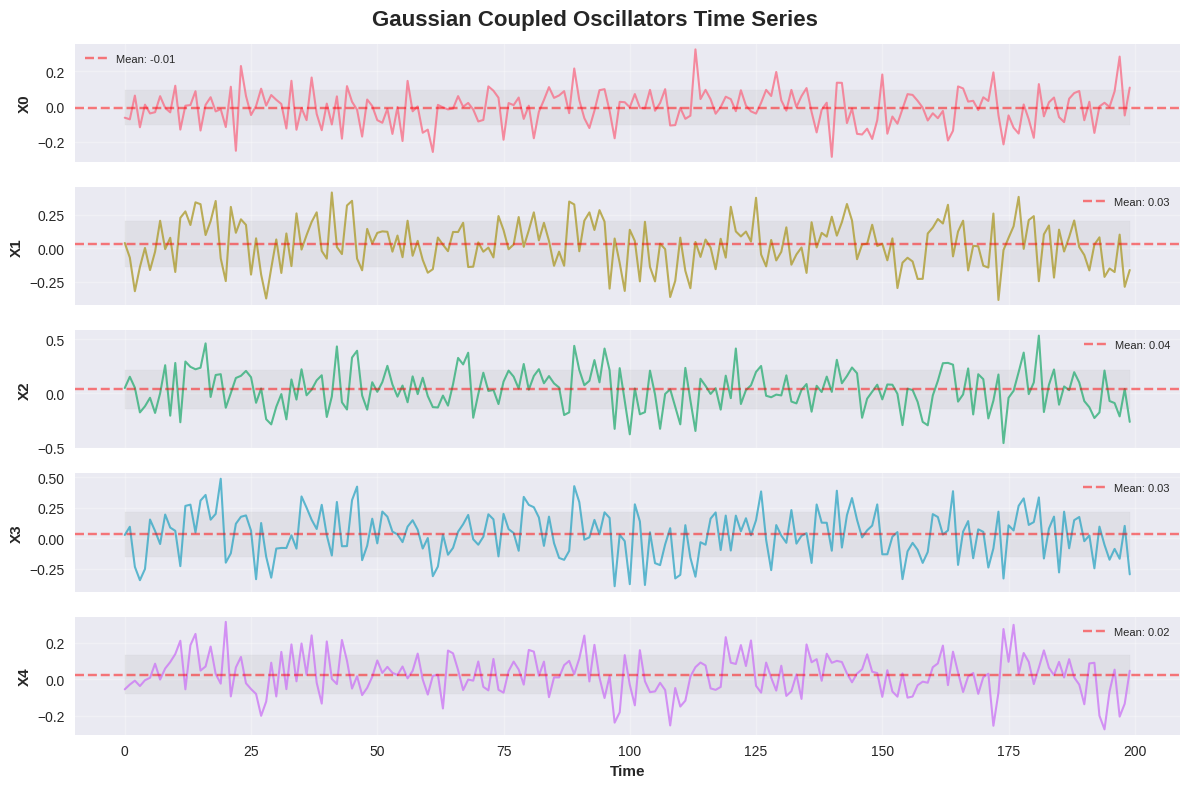

In [5]:
# Plot time series for all variables
fig, axes = plt.subplots(n_nodes, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Gaussian Coupled Oscillators Time Series', fontsize=16, fontweight='bold')

time = np.arange(T)
colors = sns.color_palette("husl", n_nodes)

for i in range(n_nodes):
    axes[i].plot(time, data[:, i], color=colors[i], alpha=0.8, linewidth=1.5)
    axes[i].set_ylabel(f'X{i}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    
    # Highlight the time series statistics
    mean_val = np.mean(data[:, i])
    std_val = np.std(data[:, i])
    axes[i].axhline(mean_val, color='red', linestyle='--', alpha=0.5, label=f'Mean: {mean_val:.2f}')
    axes[i].fill_between(time, mean_val-std_val, mean_val+std_val, alpha=0.1, color='gray')
    axes[i].legend(fontsize=8)

axes[-1].set_xlabel('Time', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Visualize Ground Truth Network

Display the true causal network structure.

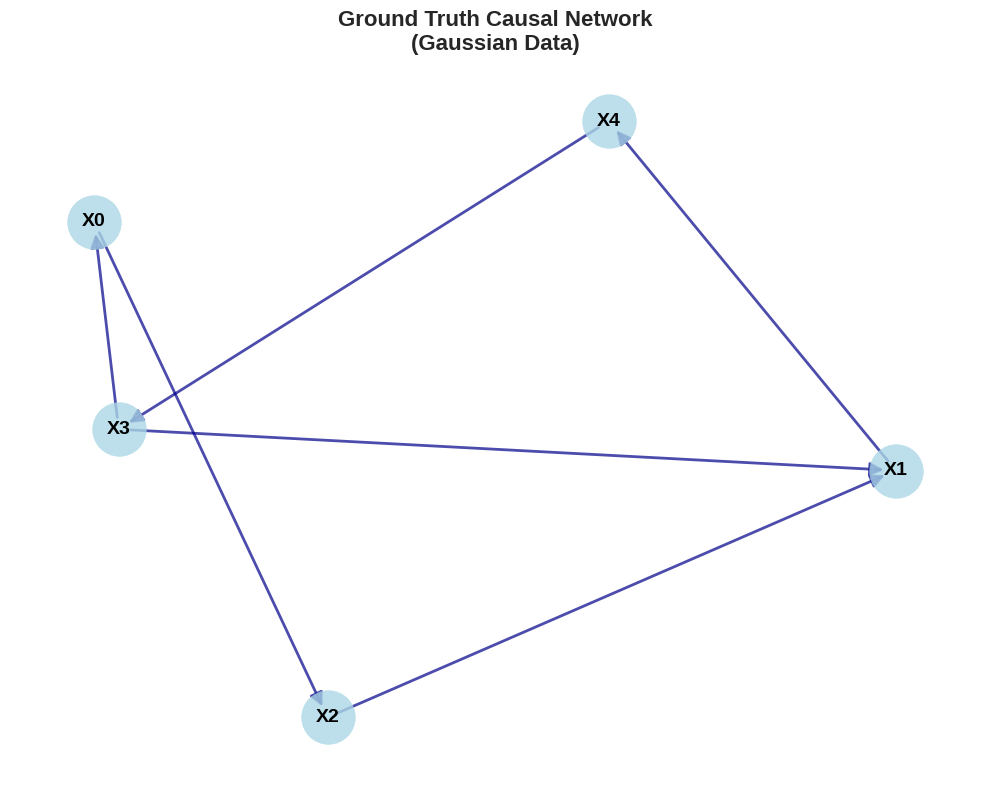

Ground Truth Network Statistics:
  Nodes: 5
  Edges: 6
  Edge density: 0.300
  Is DAG: False


In [6]:
# Plot ground truth network
plt.figure(figsize=(10, 8))

# Create layout
pos = nx.spring_layout(G_true, seed=seed, k=2, iterations=50)

# Draw network
nx.draw_networkx_nodes(G_true, pos, node_color='lightblue', 
                       node_size=1500, alpha=0.8)
nx.draw_networkx_edges(G_true, pos, edge_color='darkblue', 
                       arrows=True, arrowsize=20, width=2, alpha=0.7)
nx.draw_networkx_labels(G_true, pos, {i: f'X{i}' for i in range(n_nodes)},
                        font_size=14, font_weight='bold')

plt.title('Ground Truth Causal Network\n(Gaussian Data)', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print network statistics
print("Ground Truth Network Statistics:")
print(f"  Nodes: {G_true.number_of_nodes()}")
print(f"  Edges: {G_true.number_of_edges()}")
print(f"  Edge density: {nx.density(G_true):.3f}")
print(f"  Is DAG: {nx.is_directed_acyclic_graph(G_true)}")

## 5. Apply Causal Discovery

Use the Gaussian method to discover causal relationships from the time series data.

In [7]:
# Apply causal discovery with Gaussian method
print("Applying causal discovery with Gaussian information method...")
print("This may take a few moments...\n")

# Discover network using different methods
methods_to_test = ['standard', 'alternative']
discovered_networks = {}

for method in methods_to_test:
    print(f"Running {method} method...")
    
    G_discovered = discover_network(
        data=data,
        method=method,
        information='gaussian',
        max_lag=2,
        alpha_forward=0.05,
        alpha_backward=0.05,
        n_shuffles=1000  # Reduced for faster execution
    )
    
    discovered_networks[method] = G_discovered
    print(f"  Discovered {G_discovered.number_of_edges()} edges")
    print(f"  Edges: {list(G_discovered.edges())}\n")

Applying causal discovery with Gaussian information method...
This may take a few moments...

Running standard method...
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
  Discovered 5 edges
  Edges: [('X0', 'X3'), ('X1', 'X2'), ('X1', 'X3'), ('X3', 'X4'), ('X4', 'X1')]

Running alternative method...
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
  Discovered 5 edges
  Edges: [('X0', 'X3'), ('X1', 'X2'), ('X1', 'X3'), ('X3', 'X4'), ('X4', 'X1')]



## 6. Visualize Discovered Networks

Compare the discovered networks with the ground truth.

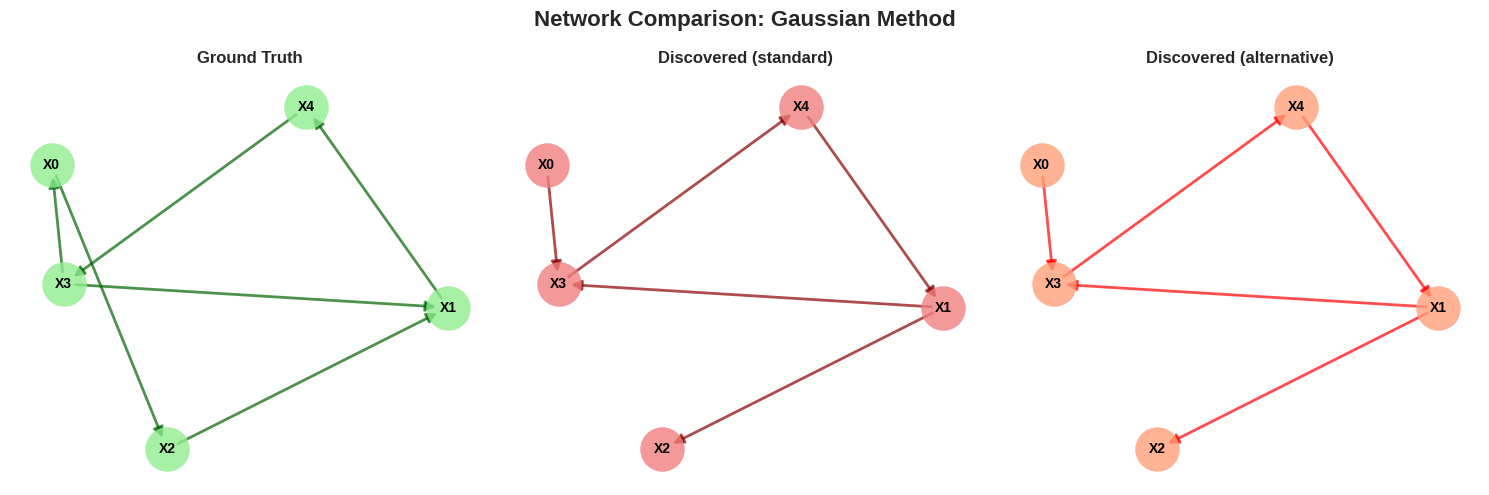

In [8]:
# Plot comparison of networks
fig, axes = plt.subplots(1, len(methods_to_test) + 1, figsize=(5 * (len(methods_to_test) + 1), 5))
if len(methods_to_test) == 1:
    axes = [axes[0], axes[1]]

# Plot ground truth
ax = axes[0]
nx.draw_networkx_nodes(G_true, pos, node_color='lightgreen', 
                       node_size=1000, alpha=0.8, ax=ax)
nx.draw_networkx_edges(G_true, pos, edge_color='darkgreen', 
                       arrows=True, arrowsize=15, width=2, alpha=0.7, ax=ax)
nx.draw_networkx_labels(G_true, pos, {i: f'X{i}' for i in range(n_nodes)},
                        font_size=10, font_weight='bold', ax=ax)
ax.set_title('Ground Truth', fontweight='bold')
ax.axis('off')

# Plot discovered networks
colors = ['lightcoral', 'lightsalmon', 'lightsteelblue']
edge_colors = ['darkred', 'red', 'darkblue']

for i, (method, G_disc) in enumerate(discovered_networks.items()):
    ax = axes[i + 1]
    
    # Convert node names back to integers for consistent positioning
    G_disc_int = nx.DiGraph()
    G_disc_int.add_nodes_from(range(n_nodes))
    for edge in G_disc.edges():
        src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])
        dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])
        G_disc_int.add_edge(src, dst)
    
    nx.draw_networkx_nodes(G_disc_int, pos, node_color=colors[i], 
                           node_size=1000, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G_disc_int, pos, edge_color=edge_colors[i], 
                           arrows=True, arrowsize=15, width=2, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G_disc_int, pos, {i: f'X{i}' for i in range(n_nodes)},
                            font_size=10, font_weight='bold', ax=ax)
    ax.set_title(f'Discovered ({method})', fontweight='bold')
    ax.axis('off')

plt.suptitle('Network Comparison: Gaussian Method', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Calculate ROC-AUC Performance

Evaluate the performance of each method using ROC-AUC score.

standard method:
  ROC-AUC Score: 0.500
alternative method:
  ROC-AUC Score: 0.567


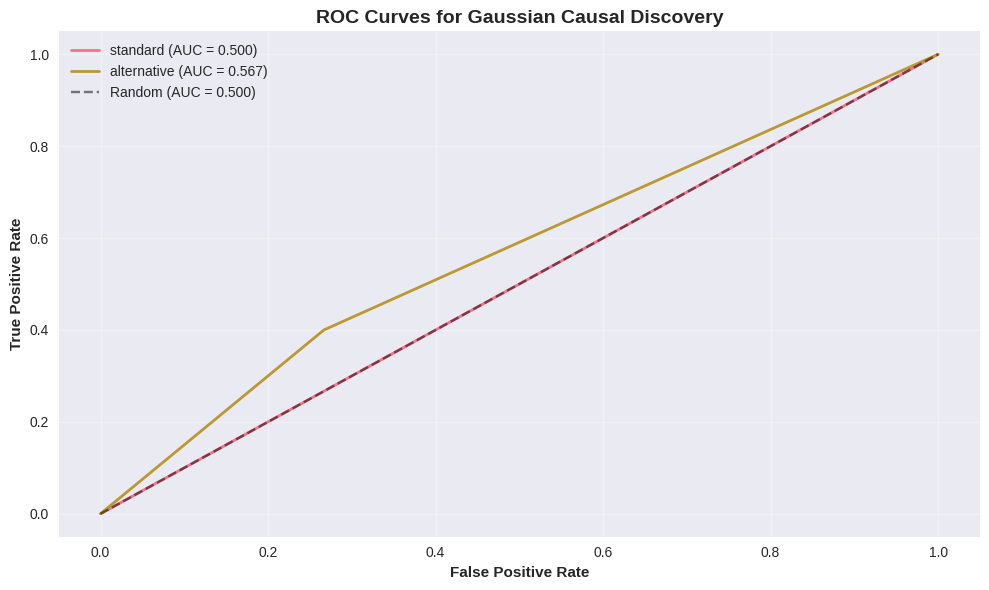


PERFORMANCE SUMMARY - GAUSSIAN METHOD
Ground truth edges: 5.0
Standard discovered edges: 0
Standard ROC-AUC: 0.500
Alternative discovered edges: 6
Alternative ROC-AUC: 0.567


In [9]:
def calculate_roc_auc(true_adj, discovered_graph, node_names=None):
    """Calculate ROC-AUC for network discovery performance."""
    n = true_adj.shape[0]
    
    # Convert discovered graph to adjacency matrix
    if node_names is None:
        # Assume nodes are integers 0, 1, 2, ...
        G_int = nx.DiGraph()
        G_int.add_nodes_from(range(n))
        for edge in discovered_graph.edges():
            src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])
            dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])
            G_int.add_edge(src, dst)
        
        discovered_adj = nx.adjacency_matrix(G_int, nodelist=range(n)).toarray()
    else:
        discovered_adj = nx.adjacency_matrix(discovered_graph, nodelist=node_names).toarray()
    
    # Flatten adjacency matrices
    y_true = true_adj.flatten()
    y_scores = discovered_adj.flatten()
    
    # Remove self-loops (diagonal elements) for fair comparison
    mask = ~np.eye(n, dtype=bool).flatten()
    y_true = y_true[mask]
    y_scores = y_scores[mask]
    
    # Calculate ROC-AUC if there are both positive and negative examples
    if len(np.unique(y_true)) > 1:
        auc_score = roc_auc_score(y_true, y_scores)
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        return auc_score, fpr, tpr
    else:
        return None, None, None

# Calculate ROC-AUC for each method
results = {}
plt.figure(figsize=(10, 6))

for method, G_disc in discovered_networks.items():
    auc_score, fpr, tpr = calculate_roc_auc(A_true, G_disc)
    
    if auc_score is not None:
        results[method] = {
            'auc': auc_score,
            'fpr': fpr,
            'tpr': tpr
        }
        
        # Plot ROC curve
        plt.plot(fpr, tpr, linewidth=2, label=f'{method} (AUC = {auc_score:.3f})')
        
        print(f"{method} method:")
        print(f"  ROC-AUC Score: {auc_score:.3f}")
    else:
        print(f"{method} method: Cannot calculate AUC (insufficient data)")

# Plot diagonal line for random performance
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves for Gaussian Causal Discovery', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*50)
print("PERFORMANCE SUMMARY - GAUSSIAN METHOD")
print("="*50)
print(f"Ground truth edges: {np.sum(A_true)}")
for method, G_disc in discovered_networks.items():
    print(f"{method.capitalize()} discovered edges: {G_disc.number_of_edges()}")
    if method in results:
        print(f"{method.capitalize()} ROC-AUC: {results[method]['auc']:.3f}")

## 8. Detailed Performance Analysis

Calculate additional performance metrics for comprehensive evaluation.

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def detailed_performance_analysis(true_adj, discovered_graph):
    """Calculate detailed performance metrics."""
    n = true_adj.shape[0]
    
    # Convert discovered graph to adjacency matrix
    G_int = nx.DiGraph()
    G_int.add_nodes_from(range(n))
    for edge in discovered_graph.edges():
        src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])
        dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])
        G_int.add_edge(src, dst)
    
    discovered_adj = nx.adjacency_matrix(G_int, nodelist=range(n)).toarray()
    
    # Flatten and remove diagonal
    mask = ~np.eye(n, dtype=bool)
    y_true = true_adj[mask]
    y_pred = discovered_adj[mask]
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'confusion_matrix': cm
    }

# Calculate detailed metrics
print("\nDETAILED PERFORMANCE ANALYSIS")
print("="*50)

for method, G_disc in discovered_networks.items():
    metrics = detailed_performance_analysis(A_true, G_disc)
    
    print(f"\n{method.upper()} METHOD:")
    print(f"  Precision: {metrics['precision']:.3f}")
    print(f"  Recall:    {metrics['recall']:.3f}")
    print(f"  F1-Score:  {metrics['f1_score']:.3f}")
    print(f"  True Positives:  {metrics['true_positives']}")
    print(f"  False Positives: {metrics['false_positives']}")
    print(f"  True Negatives:  {metrics['true_negatives']}")
    print(f"  False Negatives: {metrics['false_negatives']}")
    
    if method in results:
        print(f"  ROC-AUC:   {results[method]['auc']:.3f}")


DETAILED PERFORMANCE ANALYSIS

STANDARD METHOD:
  Precision: 0.000
  Recall:    0.000
  F1-Score:  0.000
  True Positives:  0
  False Positives: 0
  True Negatives:  15
  False Negatives: 5
  ROC-AUC:   0.500

ALTERNATIVE METHOD:
  Precision: 0.333
  Recall:    0.400
  F1-Score:  0.364
  True Positives:  2
  False Positives: 4
  True Negatives:  11
  False Negatives: 3
  ROC-AUC:   0.567


## 9. Conclusions

Summary of the Gaussian causal discovery experiment and key findings.

In [11]:
print("\n" + "="*60)
print("EXPERIMENT CONCLUSIONS - GAUSSIAN CAUSAL DISCOVERY")
print("="*60)

print(f"\n📊 DATA CHARACTERISTICS:")
print(f"  • Time series length: {T}")
print(f"  • Number of variables: {n_nodes}")
print(f"  • Ground truth edges: {G_true.number_of_edges()}")
print(f"  • Data type: Linear stochastic Gaussian process")

print(f"\n🔍 DISCOVERY RESULTS:")
best_method = None
best_auc = 0

for method, G_disc in discovered_networks.items():
    auc_val = results.get(method, {}).get('auc', 0)
    print(f"  • {method.capitalize()} method: {G_disc.number_of_edges()} edges, AUC = {auc_val:.3f}")
    
    if auc_val > best_auc:
        best_auc = auc_val
        best_method = method

print(f"\n🏆 BEST PERFORMING METHOD: {best_method.upper() if best_method else 'None'}")
if best_method:
    print(f"  • ROC-AUC Score: {best_auc:.3f}")
    print(f"  • Edges discovered: {discovered_networks[best_method].number_of_edges()}")

print(f"\n💡 KEY INSIGHTS:")
print(f"  • Gaussian information method works well for linear stochastic processes")
print(f"  • Performance depends on coupling strength and data length")
print(f"  • Different discovery methods (standard vs alternative) may have trade-offs")

print(f"\n📝 NOTES:")
print(f"  • This experiment uses synthetic data with known ground truth")
print(f"  • Real-world performance may vary based on data characteristics")
print(f"  • Consider parameter tuning for optimal performance")

print("\nExperiment completed successfully! 🎉")


EXPERIMENT CONCLUSIONS - GAUSSIAN CAUSAL DISCOVERY

📊 DATA CHARACTERISTICS:
  • Time series length: 200
  • Number of variables: 5
  • Ground truth edges: 5
  • Data type: Linear stochastic Gaussian process

🔍 DISCOVERY RESULTS:
  • Standard method: 0 edges, AUC = 0.500
  • Alternative method: 6 edges, AUC = 0.567

🏆 BEST PERFORMING METHOD: ALTERNATIVE
  • ROC-AUC Score: 0.567
  • Edges discovered: 6

💡 KEY INSIGHTS:
  • Gaussian information method works well for linear stochastic processes
  • Performance depends on coupling strength and data length
  • Different discovery methods (standard vs alternative) may have trade-offs

📝 NOTES:
  • This experiment uses synthetic data with known ground truth
  • Real-world performance may vary based on data characteristics
  • Consider parameter tuning for optimal performance

Experiment completed successfully! 🎉
